<div style='background-image: url("../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Signal Processing</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Deconvolution - Solution</div>
        </div>
    </div>
</div>

Seismo-Live: http://seismo-live.org

##### Authors:
* Stefanie Donner ([@stefdonner](https://github.com/stefdonner))
* Celine Hadziioannou ([@hadzii](https://github.com/hadzii))
* Ceri Nunn ([@cerinunn](https://github.com/cerinunn))


---

<h1>Deconvolution</h1>
<br>

In [1]:
# Cell 0 - Preparation: load packages, set some basic options  
%matplotlib inline
from __future__ import print_function
from numpy.fft import rfft, irfft, fft, ifft
import numpy as np
import scipy.signal as sp
import matplotlib.pylab as plt
from obspy.core import Trace
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16, 2)
plt.rcParams['lines.linewidth'] = 0.5

## The twin of convolution

*Deconvolution* is the reverse mathematical operation to [convolution](convolution.ipynb). It is probably the most important application in seismological/seismic data processing, e.g. for removing the instrument response of a seismometer from recorded data. Intuitively spoken, it means applying the inverse filter (or response function) on the data to recover the original data.    

Deconvolution is rarely applied in its pure mathematical form due to practical issues caused by the signal-to-noise-ratio. 

$$ y(t) = h(t) * x(t) + n(t) $$

If not done properly, the deconvolution process leads to disproportionately increased noise amplitudes. Therefore, the process needs to be constrained by a-priori information. Making use of the [convolution theorem](convolution.ipynb), *deconvolution* usually is performed in the [*frequency domain*](fourier_transform.ipynb). Here, it is a simple division:

$$ X'(\omega) = \frac{Y(\omega)+N(\omega)}{H(\omega)} $$

where $Y(\omega)$ is the raw, recorded signal spoiled by noise $N(\omega)$, $H(\omega)$ the instrument response, and $X'(\omega)$ the resulting signal, sometimes called the *restitued signal*. In a perfect world it would be identical to the original (unknown) signal $X(\omega)$.    

Two major problems of *deconvolution* lie in $H(\omega)$ being (partly) zero or close to zero and in the presence of noise. A division by zero is - a matter of common knowledge - undefined. A possible fix to this problem is e.g. the so called *waterlevel method*, basically adding a very low level of white noise to $H(\omega)$ before the division: 

$$ X'(\omega) = \frac{Y(\omega)+N(\omega)}{H(\omega)+\epsilon} $$

However, this method may not fix the problem of amplified noise completely. The second option is therefore to [*bandpass filter*](filter_basics.ipynb) the deconvolved signal, thus removing the amplified noise but keeping the wanted signal. A special bandpass filter for deconvolution is the *Wiener filter*. It makes use of a function $G(\omega)$ to obtain

$$ X'(\omega) = G(\omega) \cdot Y(\omega) $$

This function is called the *filter function* and is defined as 

$$ G(\omega) = \frac{1}{H(\omega)} \left[ \frac{ |H(\omega)|^2 }{ |H(\omega)|^2 + \frac{1}{\mathrm{SNR}(\omega)}} \right] $$

with $SNR(\omega)$ being the signal-to-noise ratio of the measured data.  

Generally, the *Wiener filter* provides better results than a simple [*bandpass filter*](filter_basics.ipynb). Therefore, it is often applied in image manipulation ($t$ and $\omega$ become 2-dimensional), e.g. in seismics. When working with 1-dimensional seismological data the *water-level method* or the [*bandpass filter*](filter_basics.ipynb) provide fair results.

---
### Exercise 

In Cell 1 we create a signal that is made up of $\sin$ functions with three different frequencies. In Cell 2 we add noise to this signal, this is called *data* noise. The percentage of noise within the signal can be varied with the variable $perc$. 
Consider the absolute amplitudes in time and frequency domain of the pure and noisy signal.

In Cell 3 we set-up a window function, which we use as *convolution function*. In Cell 4 we then convolve the two signals with the convolution function. In addition, we again add noise. This time it is *instrument noise* having its causes not in nature but in the instrument for measurement itself. It can be caused by thermal drifts of the instrument, effects of non-linearities in the construction of the instrument, or effects due to barometric pressure changes influencing the instrument. 

Cell 5 is performing the deconvolution. All results are plotted in Cell 8.

1) Have a look at the result plots, especially consider the resolution of the three initial frequencies used to create the signal. What do you observe? What happens when you increase the water level $wl$ in Cell 5 in steps of 1? 

2) Set the water level $wl$ in Cell 5 back to 0 and uncomment the lines in Cell 6 for applying a bandpass filter to the deconvolution. Run Cell 5 again bevor running Cell 6. What would be good corner frequencies for the filter and why?  What do you observe in teh result now?   

3) Run Cell 4 (convolution) again and then directly Cell 7 (Wiener deconvolution), skipping Cell 5 and 6. Describe the outcome.

4) Decrease the slope of the convolution function in the frequency domain by increasing it in the time domain ([uncertainty principle](spectral_analysis+preprocessing.ipynb) of the [Fourier transform](fourier_transform.ipynb)), i.e. reduce the value for the variable $slp$ in Cell 3. What do you observe in the outcome?

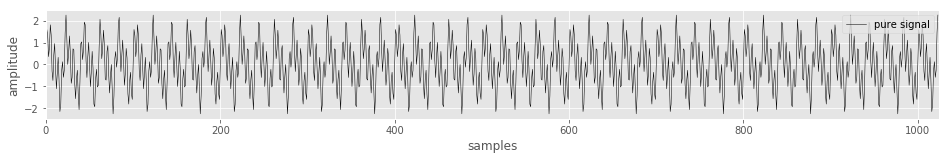

In [2]:
# Cell 1 - create signal
plt.rcParams["figure.figsize"] = (16, 2)
fs = 10         # initial: 10 ; sampling rate in Hz, must be integer
npts = 1024     # initial: 1024 ; number of samples
dur = npts/fs   # duration of signal in seconds, may be float
f1 = 1.0        # initial: 1.0, 0.5, 2.33 ; sine frequencies for signal, may be float 
f2 = 0.5
f3 = 2.3

sin1 = 0.5 * (np.sin(2*np.pi*np.arange(fs*dur)*f1/fs))
sin2 = (np.sin(2*np.pi*np.arange(fs*dur)*f2/fs))
sin3 = (np.sin(2*np.pi*np.arange(fs*dur)*f3/fs))
sig = sin1+sin2+sin3

plt.plot(sig,'k',label='pure signal')
plt.xlabel('samples')
plt.ylabel('amplitude')
plt.xlim(0,npts)
plt.legend()
plt.show()

# root mean square of signal, needed in next cell
rms_sig = np.sqrt(np.mean(sig**2))

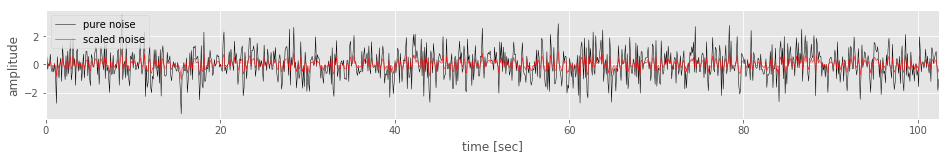

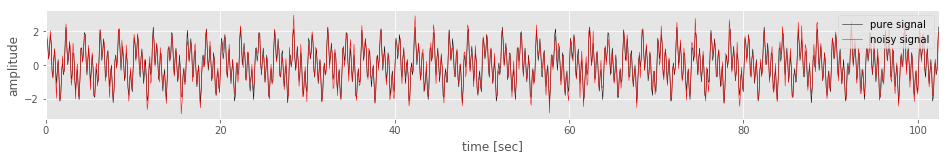

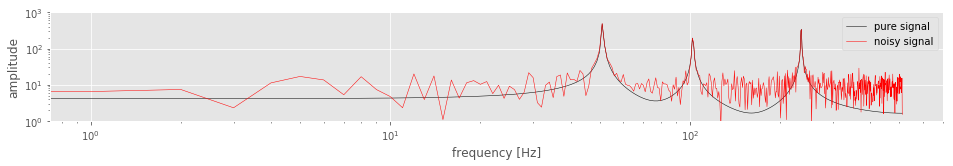

In [3]:
# Cell 2 - create 'data' noise
plt.rcParams["figure.figsize"] = (16, 2)

t = np.linspace(0, npts*(1/fs), npts)              # time axis for plotting
noise = np.random.randn(npts) 
plt.plot(t,noise,'k', label='pure noise')

rms_noise = np.sqrt(np.mean(noise**2))             # normalise noise amplitude and reduce to perc% of signal
perc = 0.3                                         # initial: 0.3 ; percentage of noise level
n = perc * rms_sig/rms_noise * noise
plt.plot(t,n,'r', label='scaled noise')
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.xlim(0,max(t))
plt.legend()
plt.show()

# add scaled noise to signal
nsig = sig + (perc * rms_sig/rms_noise * noise)

plt.plot(t,sig,'k', label='pure signal')
plt.plot(t,nsig,'r', label='noisy signal')
plt.xlim(0,max(t))
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

SIG = rfft(sig)
NSIG = rfft(nsig)
plt.loglog(abs(SIG),'k', label='pure signal')
plt.loglog(abs(NSIG),'r', label='noisy signal')
plt.ylim(1e0,1e3)
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude')
plt.legend()
plt.show()

In [4]:
# Cell 3 - create window function for convolution
fs2 = 200         # initial: 200 ; sampling rate in Hz, must be integer
npts2 = 2048      # initial: 2048
slp = 50          # initial: 50 ; slope steepness of convolution function

t2 = np.linspace(0, (npts2/2)*(1/fs2), (npts2/2))
win = np.exp(-slp*t2**2.0 )

# zero pad the window to bring on same length as signal (if necessary)
pad = np.zeros(len(sig) - len(win))
win_p = np.concatenate((win, pad), axis=0)
print('convolution function padded with zeros for', len(pad), 'samples')

convolution function padded with zeros for 0 samples


In [5]:
# Cell 4 - convolve signal with convolution function + add 'instrument' noise
sig_c_tmp = irfft( rfft(sig) * rfft(win_p)  )
nsig_c_tmp = irfft( rfft(nsig) * rfft(win_p) )

# add 'instrument' noise 
noise2 = np.random.randn(npts) 
rms_noise2 = np.sqrt(np.mean(noise2**2))            # normalise noise amplitude and reduce to perc% of signal
perc = 0.9                                          # initial: 0.9
sig_c = sig_c_tmp + (perc * rms_sig/rms_noise2 * noise2)
nsig_c = nsig_c_tmp + (perc * rms_sig/rms_noise2 * noise2)

In [6]:
# Cell 5 - deconvolution
wl = 3          # initial: 0 ; water level for deconvolution 

# bring convolution function to same length as convolved signal (if necessary)
pad = np.zeros(len(sig_c) - len(win))
win_p = np.concatenate((win, pad), axis=0)
print('convolution function padded with zeros for', len(pad), 'samples')

# deconvolve signals with/without water level
sig_dc = irfft(rfft(sig_c)/ ( rfft(win_p) + wl ) )
nsig_dc = irfft(rfft(nsig_c)/ ( rfft(win_p) + wl ) )

convolution function padded with zeros for 0 samples


In [7]:
# Cell 6 - bandpass filter after deconvolution (SET wl = 0.0 IN CELL 5 AGAIN)
#bfmin = 0.3        # initial: 0.1 Hz
#bfmax = 3.0        # initial: 10.0 Hz

#tr = Trace(data=sig_dc)
#tr.stats.sampling_rate=fs
#tr.filter('bandpass', freqmin=bfmin, freqmax=bfmax, corners=6, zerophase=True)
#sig_dc = tr.data

#tr = Trace(data=nsig_dc)
#tr.stats.sampling_rate=fs
#tr.filter('bandpass', freqmin=bfmin, freqmax=bfmax, corners=6, zerophase=True)
#nsig_dc = tr.data

In [8]:
# Cell 7 - Wiener filter
#snr = rms_sig/rms_noise
#H = fft(win_p)
#sig_dc = np.real(ifft(fft(sig_c)*np.conj(H)/(H*np.conj(H) + snr**2)))
#nsig_dc = np.real(ifft(fft(nsig_c)*np.conj(H)/(H*np.conj(H) + snr**2)))

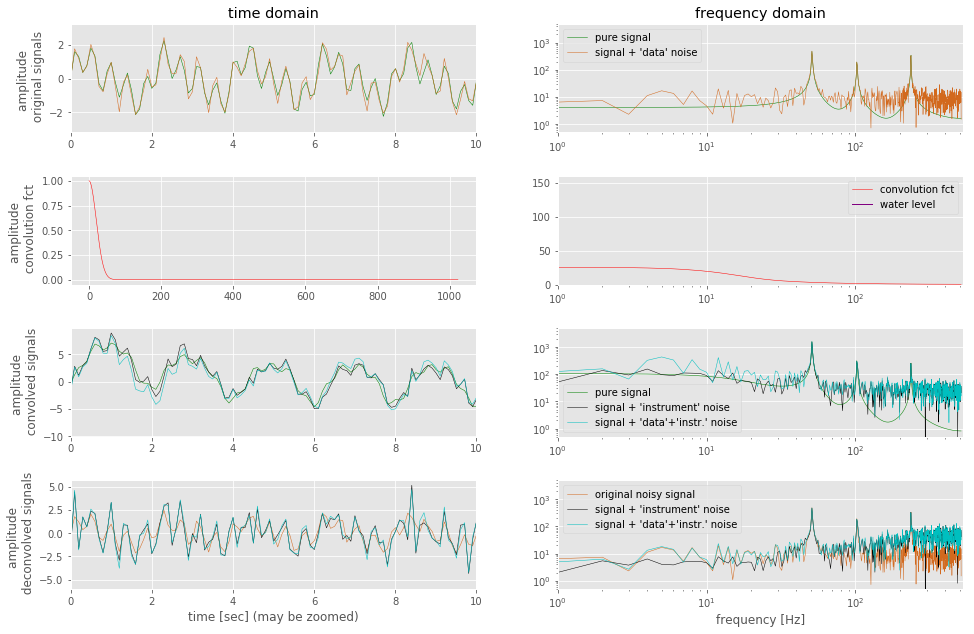

In [9]:
# Cell 8 - plot figure
# get amplitude spectrums
SIG = rfft(sig)                            # pure signal
NSIG = rfft(nsig)                          # signal with data noise
SIG_C = rfft(sig_c)                        # pure signal convolved  incl. instrument noise
SIG_C_TMP = rfft(sig_c_tmp)                # pure signal convolved without instrument noise
NSIG_C = rfft(nsig_c)                      # noisy signal convolved incl. instrument noise
NSIG_C_TMP = rfft(nsig_c_tmp)              # noisy signal convolved without instrument noise
SIG_DC = rfft(sig_dc)                      # deconvolution of signal incl. only instrument noise
NSIG_DC = rfft(nsig_dc)                    # deconvolution of signal incl. data and instrument noise
WIN = rfft(win_p)                          # convolution function

# axes limitations
xmax = 10
fxmin = 1e0
fxmax = 5.3e2
fymin = 5e-1
fymax = 5e3

plt.rcParams["figure.figsize"] = (16, 16)
plt.subplot(621)
plt.plot(t, sig, 'g')
plt.plot(t, nsig, color='chocolate')
plt.xlim(0,xmax)
plt.ylabel('amplitude \n original signals')
plt.title('time domain')

plt.subplot(622)
plt.loglog(abs(SIG),'g', label='pure signal')
plt.loglog(abs(NSIG),color='chocolate', label='signal + \'data\' noise')
plt.xlim(fxmin,fxmax)
plt.ylim(fymin,fymax)
plt.title('frequency domain')
plt.legend(loc='upper left')

plt.subplot(623)
plt.plot(win_p,'r')
plt.ylabel('amplitude \n convolution fct')

plt.subplot(624)
plt.semilogx(abs(WIN),'r', label='convolution fct')
plt.axhline(y=wl,linewidth=1, color='purple', label='water level')
plt.xlim(fxmin,fxmax)
plt.ylim(0,160)
plt.legend()

plt.subplot(625)
plt.plot(t, sig_c_tmp, 'g')
plt.plot(t, sig_c, 'k')
plt.plot(t, nsig_c, 'c')
plt.xlim(0,xmax)
plt.ylabel('amplitude \n convolved signals')

plt.subplot(626)
plt.loglog(abs(SIG_C_TMP),'g', label='pure signal')
plt.loglog(abs(SIG_C),'k', label='signal + \'instrument\' noise')
plt.loglog(abs(NSIG_C),'c', label='signal + \'data\'+\'instr.\' noise')
plt.xlim(fxmin,fxmax)
plt.ylim(fymin,fymax)
plt.legend(loc='lower left')

plt.subplot(627)
plt.plot(t, nsig, color='chocolate')
plt.plot(t, sig_dc, 'k')
plt.plot(t, nsig_dc, 'c')
plt.xlim(0,xmax)
plt.xlabel('time [sec] (may be zoomed)')
plt.ylabel('amplitude \n deconvolved signals')

plt.subplot(628)
plt.loglog(abs(NSIG), color='chocolate', label='original noisy signal')
plt.loglog(abs(SIG_DC),'k', label='signal + \'instrument\' noise')
plt.loglog(abs(NSIG_DC),'c', label='signal + \'data\'+\'instr.\' noise')
plt.ylim(fymin,fymax)
plt.xlim(fxmin,fxmax)
plt.legend(loc='upper left')
plt.xlabel('frequency [Hz]')

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

---
#### Answers

1) Already the original 'noisy' data (orange) is masking part of the signal (i. e. the three initial frequencies). However, this contribution is almost neglectable; the pure signal is clearly to see. 
Things get worse, when instrument noise comes into play as well. Noise in the higher frequencies gets increased during deconvolution, masking the signal frequencies. Only one out of the three frequencies is still clearly to see (f1 at 0.5 Hz). The other two alsmost disapear in the noise. 

When incresing the water level the noise in the higher frequencies gets surpressed during convolution. However, when increasing the water level too strongly it also surpresses part of our signal. Even when finding a good balance (around wl=3) the signal in the time domain is not very similar to the original (noisy) signal. The spectrum shows that the losses in amplitude of the three initial frequencies can not be recovered. We can only revert the instrument noise up to a specific threshold (if we are lucky) but not the natural data noise. For the interpretation of data that means we can only get an estimate of the true conditions.

2) A bandpass range from 0.3 to 3 Hz seem  to be appropriate because it is enclosing the three original frequencies very close and removeing all signal smaller or larger than that. Instrument noise gets removed effectively: in time domain the deconvolved traces of the noisy data look very similar as they did when applying the water level method. However, 
applying a bandpass filter seems to be more efficient in stabilising the deconvolution than applying a water level. In time domain, the deconvolved traces look much more similar to the original (noisy) trace than before. Also in the frequency domain, the maximum amplitudes from the three frequencies compare better.

3) Wiener deconvolution is a very stable way of deconvolution. The benefits come mainly due to the scaling with the SNR of the data. However, as stated before, when signal is already lost during convolution due to noise, it is not reconvertible. That is visible in the amplitude loss for the highest frequency at 2.3 Hz. 

4) Low-frequency noise gets much more amplified during convolution. That is also influencing the results of deconvolution. Initial signal in that range will be lost when the deconvolution is not done properly or - even worse - bogus signal will be introduced into the deconvolved data. 